In [1]:
import numpy as np
import magpylib as magpy
import pandas as pd
from magpylib.magnet import Cuboid, Cylinder, CylinderSegment
from maggeometry import n_rings, halbach_cylinder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from maghelper import get_field_on_axes, get_nonuniformity, make_flux_stream, centered_sweep_range, get_grid_mag_and_nonuniformity, make_xy_grid

0.0
[7.959436318216096e-07, 4.72027974465278e-08, 1.0264409176009655e-11]
0.25
[8.362245536749678e-07, 1.0785024497944435e-05, 3.414688306418103e-09]


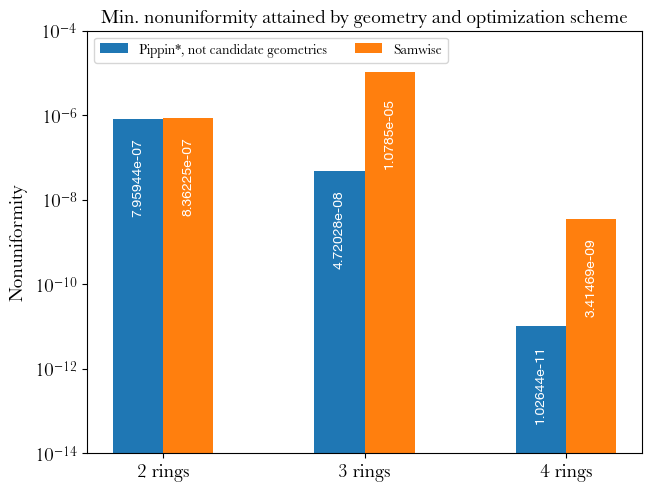

In [57]:
species = ("2 rings", "3 rings", "4 rings")
pp_nonun = [7.959436318216096e-07, 4.72027974465278E-08, 1.0264409176009655e-11]
sw_nonun = [8.362245536749678e-07, 1.0785024497944435e-05, 3.414688306418103e-09]
nring_means = {
    'Pippin*, not candidate geometries': pp_nonun,
    'Samwise': sw_nonun,
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
plt.rcParams["font.family"] = 'Baskerville'
hfont = {'fontname':'Baskerville'}
for attribute, measurement in nring_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=-70, rotation=90, color='w', fontname='Helvetica Neue')
    print(offset)
    print(measurement)
    # rects[0].set_color('purple')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nonuniformity', fontsize=14)
ax.set_title('Min. nonuniformity attained by geometry and optimization scheme', fontsize=14, **hfont)
ax.set_xticks(x + width/2, species, **hfont)
ax.legend(loc='upper left', ncols=3)
ax.set_yscale('log')
ax.set_ylim(1e-14, 1e-4)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.savefig("figs/nonuncomp.png", dpi=1000)

## For best candidate geometry

In [64]:
def plot_plane_field_strength(magnets, x_grid_bounds, y_grid_bounds, z_elev, plot_nonuniformity = True):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], 101)
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], 101)
    grid = np.array([[(x,y,z_elev) for x in ts_x] for y in ts_y])

    #get magnetic field
    mT_to_G = 10
    B = magnets.getB(grid)
    G = B * mT_to_G

    #matplotlib contour plot
    # ax = plt.figure().add_subplot(projection='3d')
    # surf = ax.plot_surface(grid[:,:,0], grid[:,:,1], B[:,:,2], linewidth=0)
    
#     Gz = G[:,:,2]
    Gmag = np.linalg.norm(G, axis=2)
    
    fig_base = make_subplots(rows=1, cols=2,
                             specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                             subplot_titles = [f'Field strength in plane z={z_elev}',
                                               f'Field nonuniformity in plane z={z_elev}'
                                              ],
                             shared_yaxes=False
                            )
    
    fig_base.add_trace(
        go.Surface(x=grid[:,:,0], y=grid[:,:,1], z=Gmag),
        row=1, col=1
    )
    
    if plot_nonuniformity:
        mid_idx = int(len(ts_x)/2)
        mid_idy = int(len(ts_y)/2)
        G_center = Gmag[mid_idx][mid_idy]
        G_non = np.abs((Gmag - G_center)/G_center)
#         G_center = Gz[mid_idx][mid_idy]
#         G_non = np.abs((Gz - G_center)/G_center)
        
        fig_base.add_trace(
            go.Surface(x=grid[:,:,0], y=grid[:,:,1], z=G_non),
            row=1, col=2
        )
    plot_height = 450
    fig_base.update_layout(
        height=plot_height,
        width=2*plot_height,
    )
    fig_base.update_traces(showscale=False)
    fig_base.show()

def get_field_on_axes(magnets, sensor_bounds, is_logscale=True):
    x_sensor_bounds, y_sensor_bounds, z_sensor_bounds = sensor_bounds
    # define sensor axis in 3d space
    sens_res = 5000
    x_senpos = np.linspace((x_sensor_bounds[0], 0, 0), (x_sensor_bounds[1], 0, 0), sens_res)
    # initialize sensor
    x_sen = magpy.Sensor(position=x_senpos)

    y_senpos = np.linspace((0, y_sensor_bounds[0], 0 ), (0, y_sensor_bounds[1], 0), sens_res)
    y_sen = magpy.Sensor(position=y_senpos)
    
    z_senpos = np.linspace((0, 0, z_sensor_bounds[0]), (0, 0, z_sensor_bounds[1]), sens_res)
    z_sen = magpy.Sensor(position=z_senpos)
    
    # read from transverse and axial sensors
    x_Bz = x_sen.getB(magnets).T[2]
    y_Bz = y_sen.getB(magnets).T[2]
    z_Bz = z_sen.getB(magnets).T[2]

    # convert from returned mT readings to Gauss
    mT_to_G = 10
    x_Gz = x_Bz * mT_to_G
    y_Gz = y_Bz * mT_to_G
    z_Gz = z_Bz * mT_to_G
    
    # set plotting configurations
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12)
    plt.rcParams.update({'font.size': 12})
    
    fig_width = 15
    fig, axs = plt.subplots(2, 3, figsize=(fig_width, 2/3*fig_width))
    axs = axs.flat
    
    # 1. plot the B_z component on each of the three sensor axes
    axs[0].set_ylabel("Gauss")
    axs[0].set_xlabel("mm")
    axs[0].plot(x_senpos[:, 0], x_Gz)
    axs[0].set_title("x-axis $B_z$ Profile")
    axs[0].grid(color='.9', which='major', axis='both', linestyle='-')

    axs[1].set_ylabel("Gauss")
    axs[1].set_xlabel("mm")
    axs[1].plot(y_senpos[:, 1], y_Gz)
    axs[1].set_title("y-axis $B_z$ Profile")
    axs[1].grid(color='.9', which='major', axis='both', linestyle='-')

    axs[2].set_ylabel("Gauss")
    axs[2].set_xlabel("mm")
    axs[2].plot(z_senpos[:, 2], z_Gz)
    axs[2].set_title("z-axis $B_z$ Profile")
    axs[2].grid(color='.9', which='major', axis='both', linestyle='-')
    
    # 2. get nonuniformity along each of the 3 axes
    x_Gnon, x_min_nonuniformity, x_max_nonuniformity, x_av_nonuniformity = get_nonuniformity(x_Gz, "x", sens_res)
    y_Gnon, y_min_nonuniformity, y_max_nonuniformity, y_av_nonuniformity = get_nonuniformity(y_Gz, "y", sens_res)
    z_Gnon, z_min_nonuniformity, z_max_nonuniformity, z_av_nonuniformity = get_nonuniformity(z_Gz, "z", sens_res)
    
    # 3. set nonuniformity plots to logscale
    if (is_logscale):
        axs[3].set_yscale("log")
        axs[4].set_yscale("log")
        axs[5].set_yscale("log")
    
    
    # 4. plot nonuniformity
    axs[3].plot(x_senpos[:, 0], x_Gnon)
    axs[3].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[3].set_ylim(x_min_nonuniformity - 1e-7, x_max_nonuniformity + 1e-7)
    axs[3].set_title('x-axis $B_z$ Non-uniformity Profile')
    axs[3].set_xlabel("mm")
    
    axs[4].plot(y_senpos[:, 1], y_Gnon)
    axs[4].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[4].set_ylim(y_min_nonuniformity - 1e-7, y_max_nonuniformity + 1e-7)
    axs[4].set_title('y-axis $B_z$ Non-uniformity Profile')
    axs[4].set_xlabel("mm")
    
    axs[5].plot(z_senpos[:, 2], z_Gnon)
    axs[5].grid(color='.9', which='major', axis='both', linestyle='-')
    axs[5].set_ylim(z_min_nonuniformity - 1e-7, z_max_nonuniformity + 1e-7)
    axs[5].set_title('z-axis $B_z$ Non-uniformity Profile')
    axs[5].set_xlabel("mm")

    # temp_fig = go.Figure(layout=go.Layout(height=600, width=600)) 
    temp_fig = go.Figure() 
    magpy.show(magnets, x_sen, y_sen, z_sen, canvas=temp_fig, style_magnetization_show=True, backend='plotly')
    # magpy.show(magnets, x_sen, y_sen, z_sen, canvas=temp_fig, style_magnetization_show=True, backend='plotly')
    sq = 10
    plot_plane_field_strength(magnets, [-sq, sq], [-sq, sq], 0)

    plt.tight_layout()
    plt.show()    

On x-axis:
Maximum B-field: 10.066 G
Central B-field: 10.066 G
Min nonuniformity: 0.0
Max nonuniformity:1.264890860579882e-07


On y-axis:
Maximum B-field: 10.066 G
Central B-field: 10.066 G
Min nonuniformity: 0.0
Max nonuniformity:1.264890860579882e-07


On z-axis:
Maximum B-field: 10.066 G
Central B-field: 10.066 G
Min nonuniformity: 0.0
Max nonuniformity:2.3960057888399994e-06




/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_91919/148764615.py:119: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_91919/148764615.py:125: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_91919/148764615.py:131: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



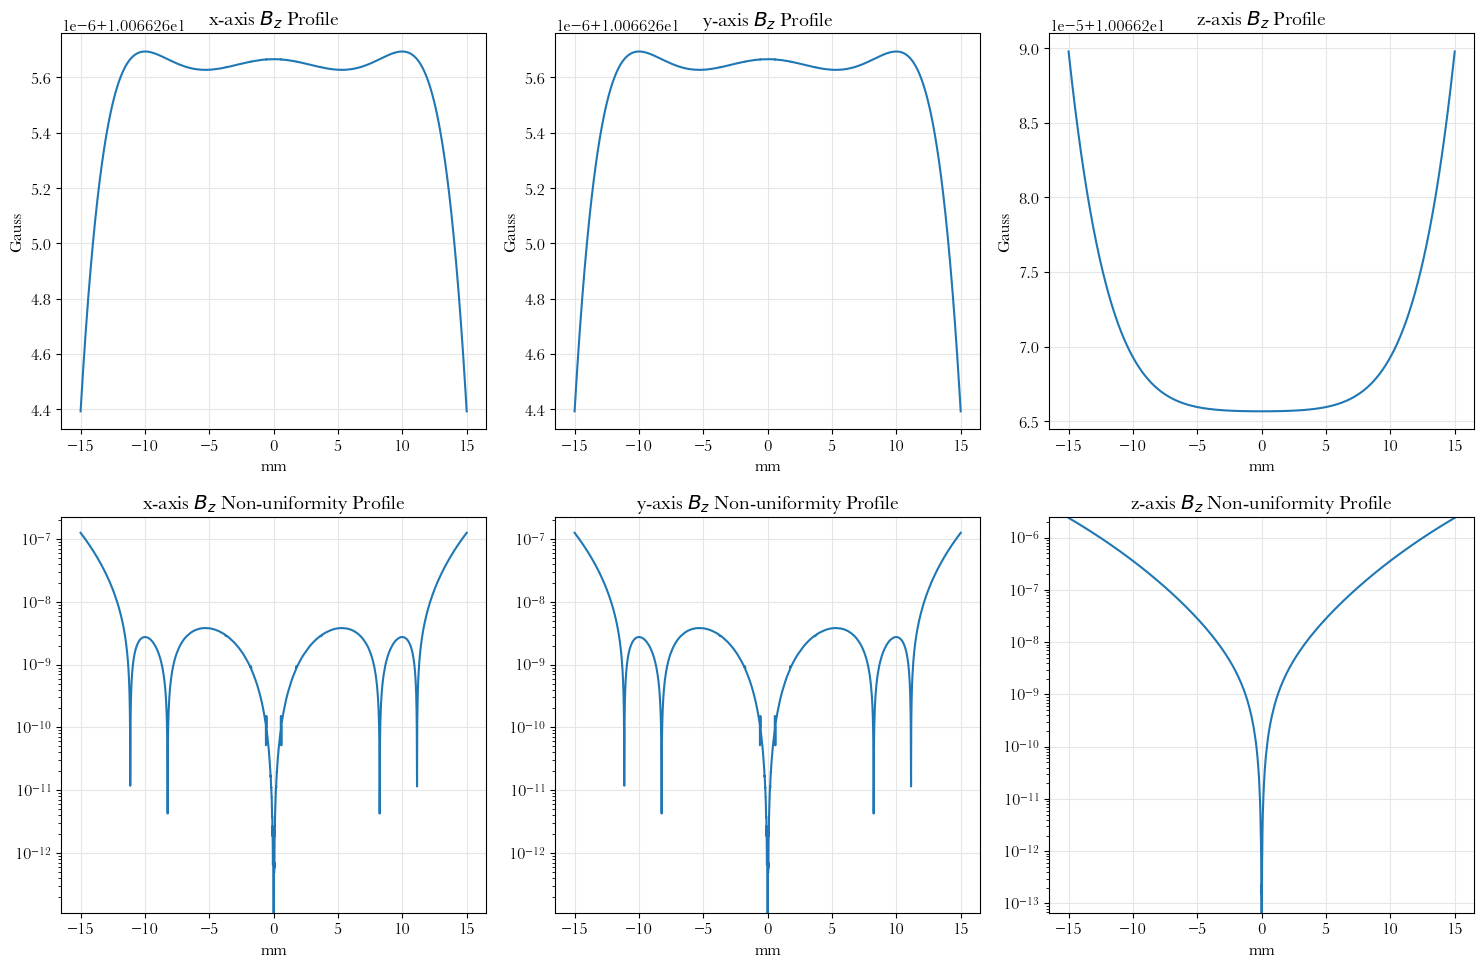

[array([3.41468831e-09, 1.00662657e+01, 1.39338163e+01, 1.60980807e+01,
       2.48949037e+00, 1.90748702e+02, 1.46026576e+02, 9.96220472e+00,
       7.78095180e+00, 1.97006309e+02, 1.80371218e+01, 9.18925991e+00,
       3.37226829e+00, 2.22733189e+02, 1.06671211e+02, 9.98618377e+00,
       1.27330873e+01, 2.17270811e+02])]
[10.066265666149437]


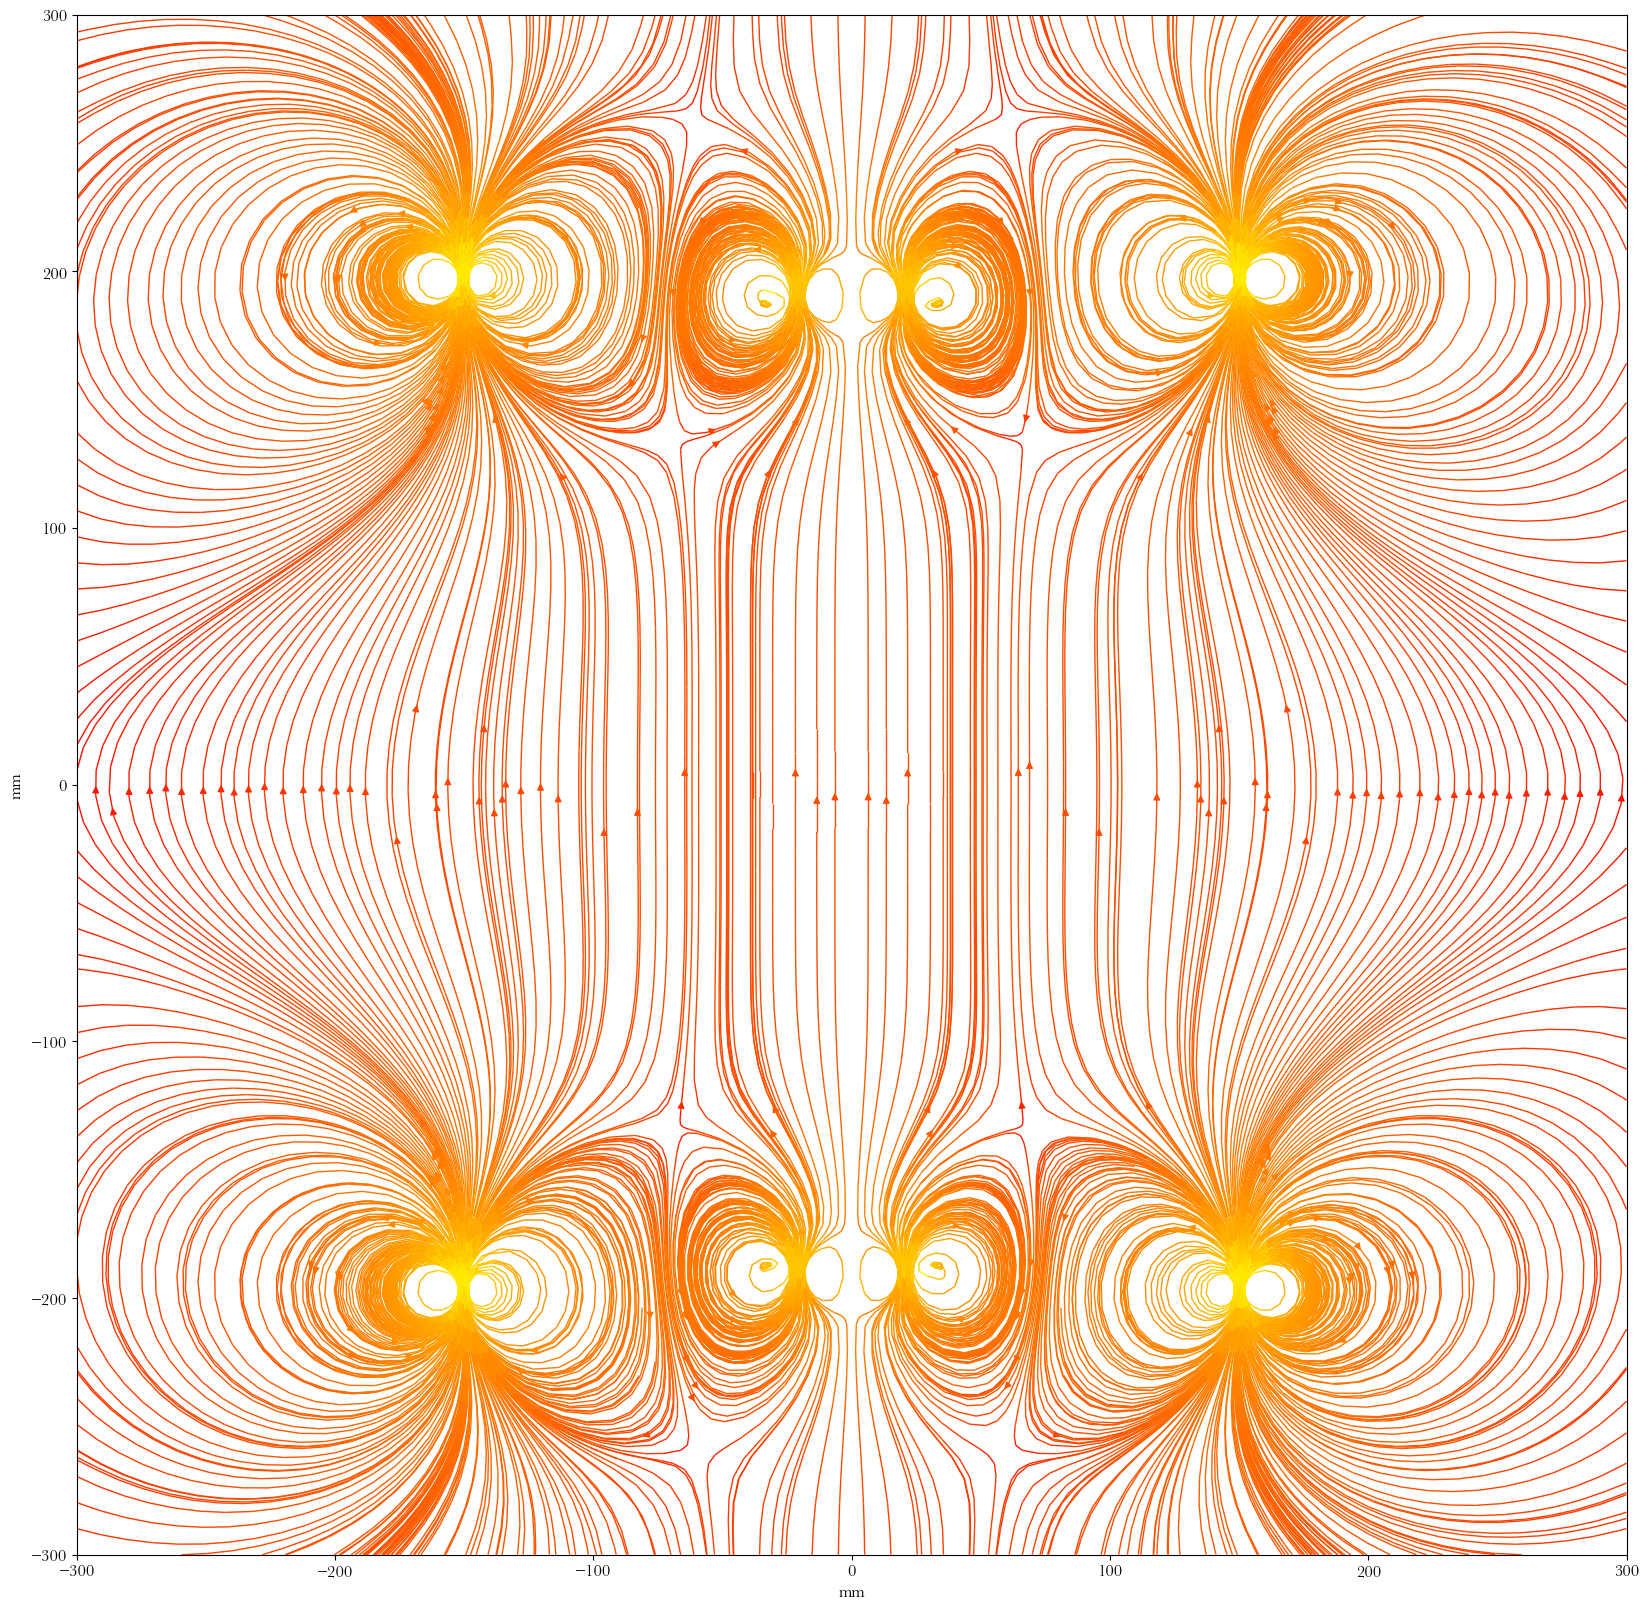

In [65]:
st1 = pd.read_csv('results/4 rings/samwise/2023_07_18_samwise_10G_objective_adaptive_stage1and2opt_4rings_1090T_50.csv')
st1 = np.delete(st1.to_numpy(), 0, axis=1) #remove first column of indices
min_nonun = st1[0][0]

def get_grid_mag_and_nonuniformity(magnets, grid, grid_res, use_z=False):
    mT_to_G = 10
    B = magnets.getB(grid)
    G = B * mT_to_G
    # find magnitude of the b-field at all points over grid
    Gmag = 0
    if use_z:
        Gmag = G[:,:,2]
    else:
        Gmag = np.linalg.norm(G, axis=2)
#     Gmag = np.sqrt(G[:,:,0]**2 + G[:,:,1]**2 + G[:,:,2]**2)
#     Gmag = G[:,:,2]
    # find magnitude of b-field at center of grid
    mid_id = int(grid_res/2)
    Gcenter = Gmag[mid_id][mid_id]
    # calculate nonuniformity with respect to center b-field
    Gnon = np.abs((Gmag - Gcenter)/Gcenter)
    max_nonuniformity = np.max(Gnon)
    av_nonuniformity = np.sum(Gnon) / grid_res**2
    return Gmag, Gnon, Gcenter, av_nonuniformity, max_nonuniformity

Br = 1.09e3
mag_dir = (0,0,1)
mirror1_z = True
ringset_1_config = [Br, mag_dir, mirror1_z]

r = 1.09e3
mag_dir = (0,0,1)
mirror2_z = True
ringset_2_config = [Br, mag_dir, mirror2_z]

grid_res = 101
grid = make_xy_grid([-10, 10], [-10, 10], grid_res)
results2_nonun = []
results2_g_center = []
results2_x = [st1[0]]
for x in results2_x:
#     innerrad1, width1, thickness1, innerrad2, width2, thickness2, dist2 = x
    obj_ring_config=[[*ringset_1_config, *x[2:6]], [*ringset_2_config, *x[6:10]]]
    magnets = n_rings(obj_ring_config)
    Gmag, Gnon, center_field, av_nonuniformity, max_abs_nonuniformity = get_grid_mag_and_nonuniformity(magnets, grid, grid_res)
#     results2_nonun.append(obj1_nonuniformity(x))
    results2_g_center.append(center_field)
    sens_len = 15
    get_field_on_axes(magnets, [[-sens_len, sens_len], [-sens_len, sens_len], [-sens_len, sens_len]], True)

    x_bounds = [-300, 300]
    z_bounds = [-300, 300]
    make_flux_stream(magnets, x_bounds, z_bounds, [])
print(results2_x)
# print(results2_fun)
# print(results2_nonun)
print(results2_g_center)